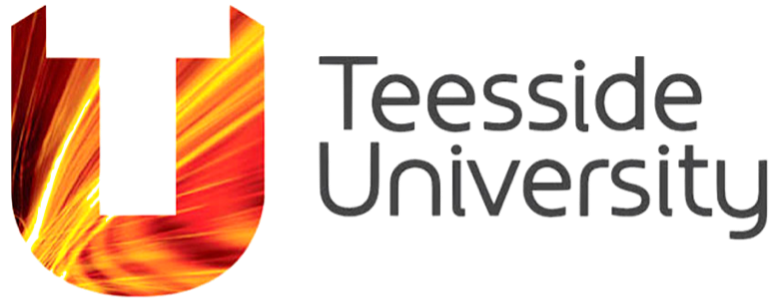
# **BRAIN TUMOUR MRI CLASSIFICATION USING DEEP LEARNING**
## **MODULE: DEEP LEARNING(CIS4050-N)**
### PATEL SNEHALKUMAR RAJESHBHAI(E4202433), 
### CAMPBELL CONNOR(A0031646), 
### WELFORD CHLOE(A0105592), 
### RANGANATHA PALLAVI(S3417639)
### MILLS-NKETSIAH, EKOW (E4041159)

This notebook is for the Deep Learning ICA Group 5 work. The aim for this notebook is to take images from the brain-tumour-mri-dataset, pre process it, and train various models on the dataset. We will then compare the effectiveness of the selected models and conclude which one would be the best use case when deployed to a hospital environment.

- NOTE: The Entire Notebook has been developed in a Kaggle notebook and executed using a GPU P100. 

Import required libraries. I then also do a check to make sure the GPU is enabled, and throw an error if there isn't one enabled, otherwise things will take a long time to load.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, save_img
from sklearn.model_selection import train_test_split
from collections import Counter
import os
import shutil
import cv2

if tf.config.list_physical_devices('GPU') == []:
    raise Exception("Please enable GPU by going to: Settings > Accelerator")
else:
    print("GPU Selected:", tf.config.list_physical_devices('GPU'))

GPU Selected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Set the path to the brain tumour datasets, both training and testing.

In [20]:
training_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
testing_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"

This function takes an image, grabs it's height and width and, if it is smaller than the required size, pads the image out. I filter out larger images as the crop_or_pad method makes the larger images way too zoomed in and loses a lot of the detail. Then every image gets extra padding on all sides so that no data is lost at the edge of the image.

In [21]:
def pad_image(image, target_height=224, target_width=224):
    height, width, channels = image.shape
    if height > 224 or width>224:
        padded_image = image
    else:
        padded_image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    height, width, channels = padded_image.shape
    paddings = tf.constant([[20, 20], [20, 20], [0, 0]])
    padded_image = tf.pad(padded_image, paddings, mode='CONSTANT', constant_values=0)
    return padded_image

This function takes a list of image paths and associated labels, as well as the name of which split I would like to create. From here it loops through each image in the list and pads it using the function described above. Once it is padded, it saves the image to the appropriate folder based on it's label and the split name given.

In [22]:
def save_images(image_paths, labels, split_name):
    print(f"Saving {split_name} data.")
    for src_path, label in zip(image_paths, labels):
        split_dir = os.path.join(output_dir, split_name, label)
        if not os.path.exists(split_dir):
            os.makedirs(split_dir)

        image = tf.image.decode_jpeg(tf.io.read_file(src_path), channels=3)
        padded_image = pad_image(image)

        dst_path = os.path.join(split_dir, os.path.basename(src_path))
        tf.io.write_file(dst_path, tf.image.encode_jpeg(padded_image))

Now I can create the output directories ready to be saved to and then save each of the images. To get the desired split without manually trying to count using an iterator, I make use of train_test_split. Firstly I create 2 lists, one for all of the image paths and another for all of the labels. This means that image[0] will belong to the class represented in label[0]. This had to be done as train_test_split needs 2 lists of equal length.
Once I have the lists I can split them 70/15/15 train/val/test and save them to the appropriate output directories in /kaggle/working. This split can be tweaked during model tuning if the model looks to be over or under fitting.

In [23]:
inputs = [training_path, testing_path]
output_dir = "/kaggle/working/dataset"

splits = ["train", "val", "test"]
for split in splits:
    split_dir = os.path.join(output_dir, split)
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

image_paths = []
labels = []

for folder in inputs:
    for class_name in os.listdir(folder):
        print(f"Copying {folder}: {class_name}")
        class_dir = os.path.join(folder, class_name)
        for image_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

save_images(train_paths, train_labels, "train")
save_images(val_paths, val_labels, "val")
save_images(test_paths, test_labels, "test")

print("Datasets saved successfully.")

Copying /kaggle/input/brain-tumor-mri-dataset/Training: pituitary
Copying /kaggle/input/brain-tumor-mri-dataset/Training: notumor
Copying /kaggle/input/brain-tumor-mri-dataset/Training: meningioma
Copying /kaggle/input/brain-tumor-mri-dataset/Training: glioma
Copying /kaggle/input/brain-tumor-mri-dataset/Testing: pituitary
Copying /kaggle/input/brain-tumor-mri-dataset/Testing: notumor
Copying /kaggle/input/brain-tumor-mri-dataset/Testing: meningioma
Copying /kaggle/input/brain-tumor-mri-dataset/Testing: glioma
Saving train data.
Saving val data.
Saving test data.
Datasets saved successfully.


I would like to ensure that the saving has worked correctly and that the distribution is as desired. This loop simply counts the number of images per folder and displays it.

In [24]:
for folder in os.listdir(output_dir):
    for class_name in os.listdir(os.path.join(output_dir, folder)):
        print(f"Total {folder} {class_name} images:", len(os.listdir(os.path.join(output_dir, folder, class_name))))

Total train glioma images: 1135
Total train notumor images: 1400
Total train pituitary images: 1230
Total train meningioma images: 1151
Total val glioma images: 243
Total val notumor images: 300
Total val pituitary images: 263
Total val meningioma images: 247
Total test glioma images: 243
Total test notumor images: 300
Total test pituitary images: 264
Total test meningioma images: 247


Create a new ImageDataGenerator which will normalise all of the images to a scale from 0,1 instead of 0,255. I then specify some augmentation parameters so that each epoch of the model will get a new set of images to use that are randomly augmented. This is a much more efficient way than manually augmenting all of the images at once and re-saving them. I attempted this and it took 40 minutes and then crashed my browser, which would not be very effective when coming back to work on this notebook again.

I make sure to only use minimal augmentation parameters as the model needs to remain focused on MRI scans. As the scans are taken by a machine they should only be distorted slightly as they are very repeatable images. I only flip horizontally too as it isn't likely that an MRI of someones head is going to be flipped upside down randomly. Studies have shown that minor augmentation of MRI scans does create a more robust model.

In [25]:

data_generator = ImageDataGenerator(
    rescale=1./255,
    fill_mode="nearest",
    width_shift_range=0.05,
    height_shift_range=0.05,
    #zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=10,
    brightness_range=[0.8,1.2]
)

In [26]:
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
val_dir = os.path.join(output_dir, "val")

train_data = data_generator.flow_from_directory(
    train_dir,
    batch_size = 32,
    target_size = (224,224),
    class_mode = "categorical",
    color_mode = "rgb",
    seed = 60
)
no_aug = ImageDataGenerator(rescale=1./255)

val_data = no_aug.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    seed=60
)

test_data = no_aug.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    seed=60
)

Found 4916 images belonging to 4 classes.
Found 1053 images belonging to 4 classes.
Found 1054 images belonging to 4 classes.


I will now begin to explore each dataset and then process it ready for the model. Firstly, I validate the target labels are correct and assign them to a variable.

In [27]:
print(f"Targets: {train_data.class_indices}")
target_labels = list(train_data.class_indices.keys())

Targets: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


I first get a batch of images from the image generator, then view the shape of the images and labels. Then, I plot a given amount of images from each of the 4 targets by looping through each image and only plotting it if it is equal to the target that I am looking for. I do this for as many times as the variable calls for. I then break out of the loop and start again, this time looking for the next target. The loop stops once all 4 targets have been plotted successfully. I do this using matplotlib, making use of a dynamically generated subplot which changes size depending on ther targets and number of images per target to nicely display each set of images.

Images Shape: (32, 224, 224, 3)
Labels Shape: (32, 4)


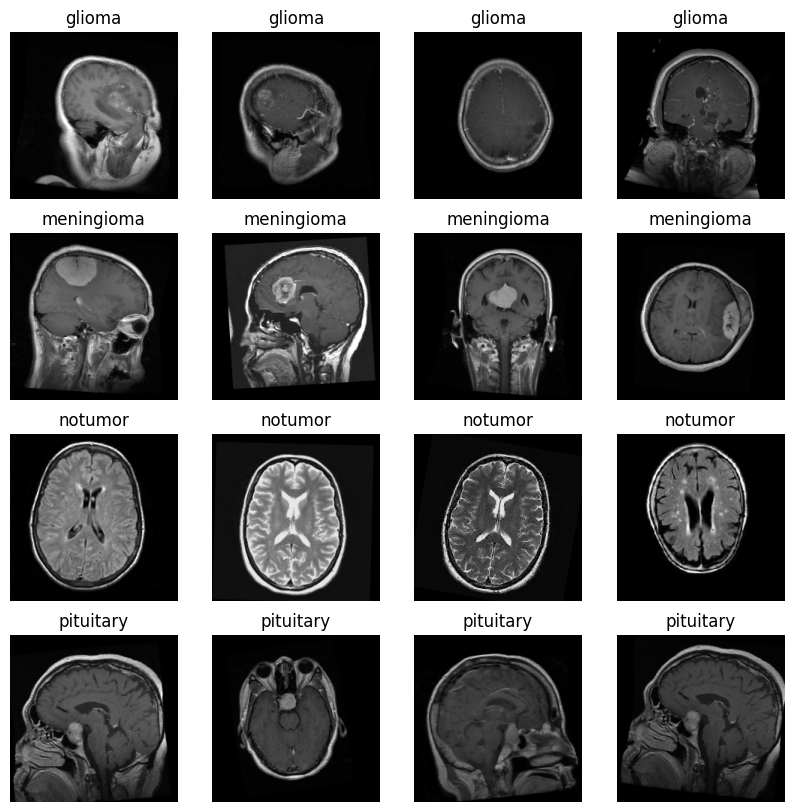

In [28]:
images, labels = next(train_data)

print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}") 

target_count = len(train_data.class_indices)
images_per_target = 4
plt.figure(figsize=(10, 10))

for target in range(target_count):
    count = 0
    for i in range(len(images)):
        if np.argmax(labels[i]) == target:
            ax = plt.subplot(target_count, images_per_target, target * images_per_target + count + 1)
            plt.imshow(images[i])
            plt.title(list(train_data.class_indices.keys())[target])
            plt.axis('off')
            count += 1
            if count == images_per_target:
                break
plt.show()

I want to see the distribution of each target in all 3 splits, to ensure there isn't anything being over-represented compared to the others. To do this I create a function which will plot the number of each files per folder for training, validation and testing. I just have to create a subplot and input each of the 3 axes that are generated by matplotlib.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


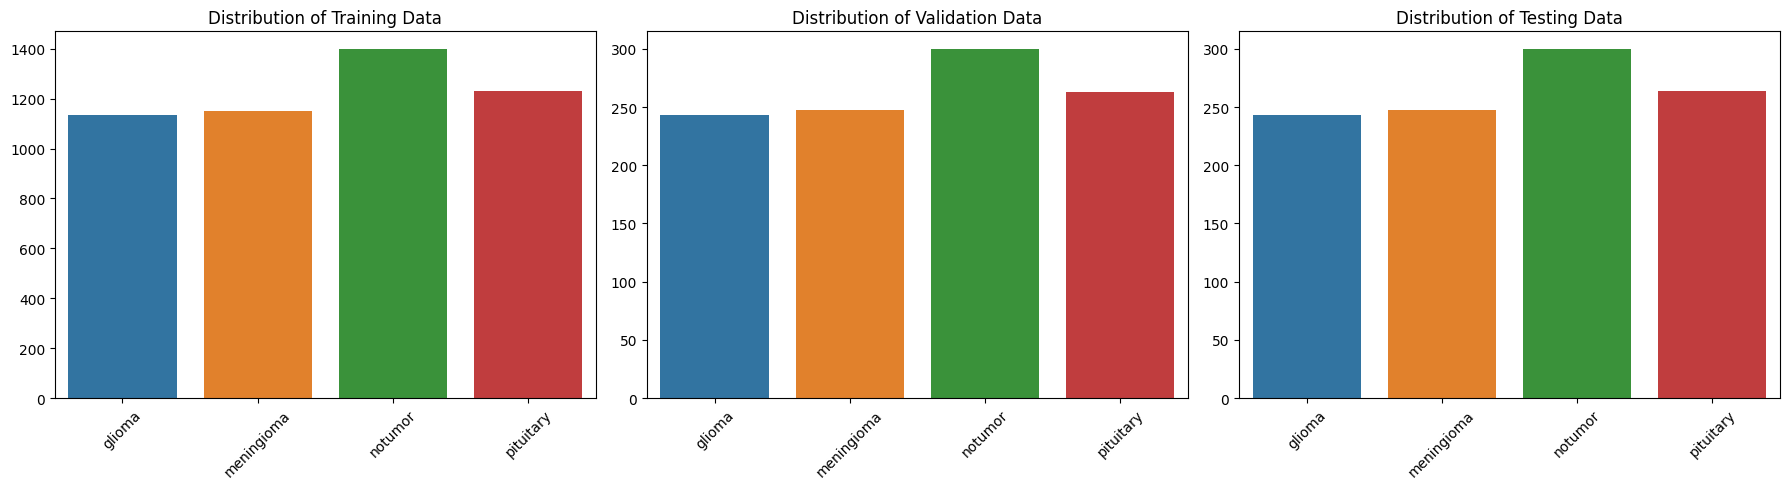

In [29]:
def plot_class_distribution(data, title, ax):
    filepaths = data.filepaths
    targets_in_dataset = [filepath.split('/')[-2] for filepath in filepaths]
    target_counts = Counter(targets_in_dataset)

    sns.barplot(x=list(data.class_indices.keys()), y=list(target_counts.values()), ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_class_distribution(train_data, "Distribution of Training Data", axes[0])
plot_class_distribution(val_data, "Distribution of Validation Data", axes[1])
plot_class_distribution(test_data, "Distribution of Testing Data", axes[2])

plt.tight_layout()
plt.show()

The distribution looks really even between all 3 sets of data good, and you would expect there to be more notumor occurrences than any of the other classes in the dataset since in a real world scenario that should be the most likely outcome. The dataset is now ready to train and validate a model.

# **MODEL IMPLIMENTATION**
To prepare the dataset for training, validation, and testing, we utilized the image_dataset_from_directory method provided by TensorFlow Keras. This method allows efficient loading of image data directly from the directory structure, which is particularly useful when dealing with large-scale datasets such as medical images.

- had to use image_dataset_from_directory() to increase accuracy, integrates better with modern TensorFlow workflows. 
- We first use `ImageDataGenerator.flow_from_directory()` to organize the original dataset into a standard structure with `train`, `val`, and `test` directories. This step is not used for model training but only for dataset creation. 
- We then use TensorFlow's `image_dataset_from_directory()` to load the structured data efficiently as `tf.data.Dataset` objects for training, validation, and testing. This ensures compatibility with modern TensorFlow workflows and improves performance.
- Images are resized to 224x224 and labels are one-hot encoded for multi-class classification.
- We keep shuffle=False to maintain a fixed order for accurate result interpretation for test data.
- We reserve the test dataset for final evaluation to ensure unbiased performance metrics. During training, we only use the training set for learning and the validation set to monitor and prevent overfitting."
- We retrieve class names from the training dataset because all datasets share the same folder structure, and .class_names will be the same across them. Using train_ds.class_names is safe and convenient.
- To perform the classification of brain tumors from MRI images, we experimented with both transfer learning approaches and a custom Convolutional Neural Network (CNN) built from scratch. This allowed us to compare the effectiveness of off-the-shelf pre-trained models with a task-specific architecture.

In [30]:

# Loading the training dataset from the specified directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical'
)

# Loading the test dataset for final evaluation after training
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical',
    shuffle=True
)

# Loading the validation dataset to monitor model performance during training
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical',
    shuffle=True
)

Found 4916 files belonging to 4 classes.
Found 1054 files belonging to 4 classes.
Found 1053 files belonging to 4 classes.


**Starting with:**
- Importing pre-trained models for transfer learning.
- Getting tools to build and train the model.
- Adding CNN layers to design the network.
- Importing tools to check model accuracy and results.

In [31]:
# Importing pre-trained deep learning models for transfer learning
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet121

# Importing model-building and training tools
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.activations import swish

# Importing layers used to build CNN architectures
import time
import tensorflow as tf
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout,Conv2D, MaxPooling2D, Flatten,Input, 
Activation, GlobalAveragePooling2D)

# Importing evaluation tools from sklearn for classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns


# **1. ResNet50 Model**

**In this part, :**

- Loading the ResNet50 model with pre-trained ImageNet weights, removing the top layer to add our own.
- Freezing the base layers to keep the learned features and avoid retraining them.
- Adding custom layers (pooling, dropout, and dense) to adapt the model for our classification task.
- Defining the final model by combining the ResNet50 base with our custom head.
- Compiling the model with the Adam optimizer and using categorical crossentropy as the loss function.
- Training the model for diffrent epochs while validating it with the validation dataset.

In [32]:
# Loading the base ResNet50 model with pre-trained ImageNet weights.
RN50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the convolutional base to retain pre-trained features and prevent updates during training.
RN50_base.trainable = False  

# Adding custom classification layers on top of ResNet50.
x = RN50_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='swish')(x)
x = Dropout(0.3)(x)
RN50_prediction = Dense(len(train_ds.class_names), activation='softmax')(x)

# Defining the final model by connecting the base and custom head.
RN50 = Model(inputs=RN50_base.input, outputs=RN50_prediction)

# Compiling the model using Adam optimizer and categorical crossentropy loss.
RN50.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model for 15 epochs with validation at each step
RN50_history = RN50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 242ms/step - accuracy: 0.6022 - loss: 1.0571 - val_accuracy: 0.8889 - val_loss: 0.3403
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.8280 - loss: 0.4414 - val_accuracy: 0.9031 - val_loss: 0.2571
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.8573 - loss: 0.3683 - val_accuracy: 0.9098 - val_loss: 0.2521
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8730 - loss: 0.3280 - val_accuracy: 0.9250 - val_loss: 0.2112
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.8888 - loss: 0.2971 - val_accuracy: 0.9335 - val_loss: 0.2016
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.8962 - loss: 0.2740 - val_accuracy: 0.9259 - val_loss: 0.2017
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.8989 - loss: 0.2586 - val_accuracy: 0.9354 - val_loss: 0.1842
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step -

**ResNet50 Testing Before Tuning**

In this section, :
- Creating lists to store true and predicted labels.
- Generating predictions on the test dataset using the trained ResNet50 model.
- Comparing predictions with actual labels to evaluate performance.
- Calculating the confusion matrix to see how the model is classifying each class.
- Creating a classification report to display precision, recall, and F1-score before tuning.
- Computing the overall accuracy to measure how well the model is performing.


In [33]:
# Testing Before Tunning  

# Initializing lists
Y_true_rn_base = []
Y_pred_rn_base = []

# Generating predictions
for images, labels in test_ds:
    preds = RN50.predict(images, verbose=0)
    Y_pred_rn_base.extend(np.argmax(preds, axis=1))
    Y_true_rn_base.extend(np.argmax(labels.numpy(), axis=1))

# Confusion Matrix
cm_rn_base = confusion_matrix(Y_true_rn_base, Y_pred_rn_base)

# classification report Before tunning
reoprt_rn_base = classification_report(Y_true_rn_base, Y_pred_rn_base, target_names=train_ds.class_names)

# overall  accuracy
acc_rn_base = accuracy_score(Y_true_rn_base, Y_pred_rn_base)

****ResNet50 Fine-tuning with Early Stopping****

In this part, :
- Setting up early stopping to monitor validation loss and prevent overfitting by stopping training if the model stops improving for 3 epochs.
- Unfreezing the base ResNet50 layers so the entire model can be fine-tuned on our dataset.
- Recompiling the model with a lower learning rate to carefully adjust the pre-trained weights.
- Training the model again, starting from where the last training left off, while letting early stopping decide when to stop if no further improvements are seen.

In [34]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

# Adding EarlyStopping to prevent overfitting in fine tuning
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

callbacks_RN = [early_stop, reduce_lr]

# Recompile after unfreezing
RN50_base.trainable = True

RN50.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

# Train with early stopping
RN50_finetune_history = RN50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=45,
    initial_epoch=RN50_history.epoch[-1] + 1,
    callbacks=callbacks_RN
)

Epoch 21/45
77/77 ━━━━━━━━━━━━━━━━━━━━ 113s 713ms/step - accuracy: 0.8317 - loss: 0.7973 - val_accuracy: 0.9136 - val_loss: 0.4538 - learning_rate: 1.0000e-04
Epoch 22/45
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - accuracy: 0.9655 - loss: 0.3655 - val_accuracy: 0.9288 - val_loss: 0.3858 - learning_rate: 1.0000e-04
Epoch 23/45
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.9883 - loss: 0.2968 - val_accuracy: 0.9164 - val_loss: 0.3932 - learning_rate: 1.0000e-04
Epoch 24/45
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.9970 - loss: 0.2625 - val_accuracy: 0.9421 - val_loss: 0.3482 - learning_rate: 1.0000e-04
Epoch 25/45
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.9984 - loss: 0.2486 - val_accuracy: 0.9411 - val_loss: 0.3392 - learning_rate: 1.0000e-04
Epoch 26/45
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.9996 - loss: 0.2387 - val_accuracy: 0.9421 - val_loss: 0.3495 - learning_rate: 1.0000e-04
Epoch 27/45
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/st

****ResNet50 Post-Tuning Testing****

In this section :

- Predicting labels on the test set using the fine-tuned model.
- Comparing predictions with true labels.
- Generating a confusion matrix and classification report.
- Calculating overall accuracy.

In [35]:
# Testing After Tunning 

# Initializing lists
Y_true_rn_ft = []
Y_pred_rn_ft = []

# Generating predictions
for images, labels in test_ds:
    preds = RN50.predict(images, verbose=0)
    Y_pred_rn_ft.extend(np.argmax(preds, axis=1))
    Y_true_rn_ft.extend(np.argmax(labels.numpy(), axis=1))

# Confusion Matrix
cm_rn_ft = confusion_matrix(Y_true_rn_ft, Y_pred_rn_ft)

# classification report After tunning
report_rn_ft = classification_report(Y_true_rn_ft, Y_pred_rn_ft, target_names=train_ds.class_names)

# overall  accuracy
acc_rn_ft = accuracy_score(Y_true_rn_ft, Y_pred_rn_ft)

****ResNet50 Visualizing Training Accuracy and Loss of RestNet50 Model****
:

- Combining training history from both the initial training and fine-tuning phases.
- Plotting accuracy and loss for training and validation sets across all epochs.
- Marking the start of fine-tuning with a vertical line to show progress before and after.

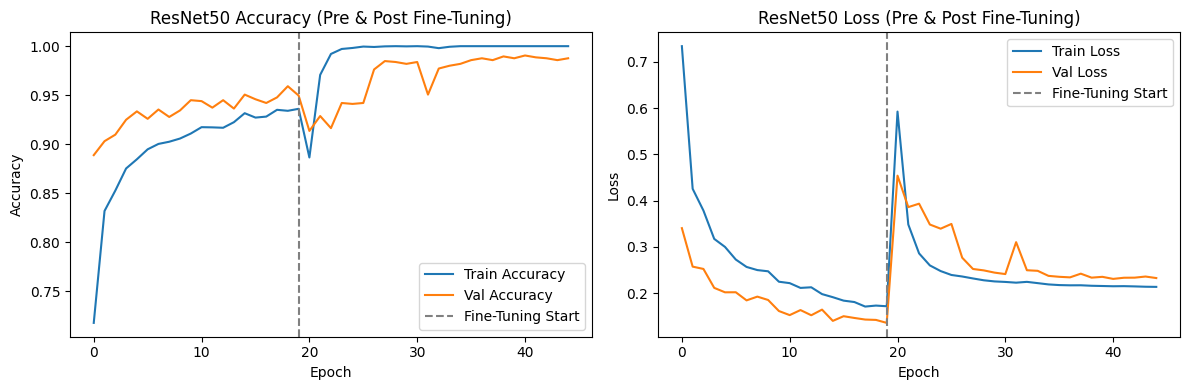

In [36]:
# Combine history from base training and fine-tuning
full_history_RN50 = {}
for key in RN50_history.history:
    full_history_RN50[key] = RN50_history.history[key] + RN50_finetune_history.history[key]

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(full_history_RN50['accuracy'], label='Train Accuracy')
plt.plot(full_history_RN50['val_accuracy'], label='Val Accuracy')
plt.axvline(x=len(RN50_history.history['accuracy'])-1, color='gray', linestyle='--', label='Fine-Tuning Start')
plt.title('ResNet50 Accuracy (Pre & Post Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(full_history_RN50['loss'], label='Train Loss')
plt.plot(full_history_RN50['val_loss'], label='Val Loss')
plt.axvline(x=len(RN50_history.history['loss'])-1, color='gray', linestyle='--', label='Fine-Tuning Start')
plt.title('ResNet50 Loss (Pre & Post Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

****Comparing ResNet50 Confusion Matrices****
Next :

- Displaying confusion matrices before and after fine-tuning.
- Placing them side by side to clearly compare classification improvements.
- Labeling plots to highlight changes in model accuracy and class prediction.

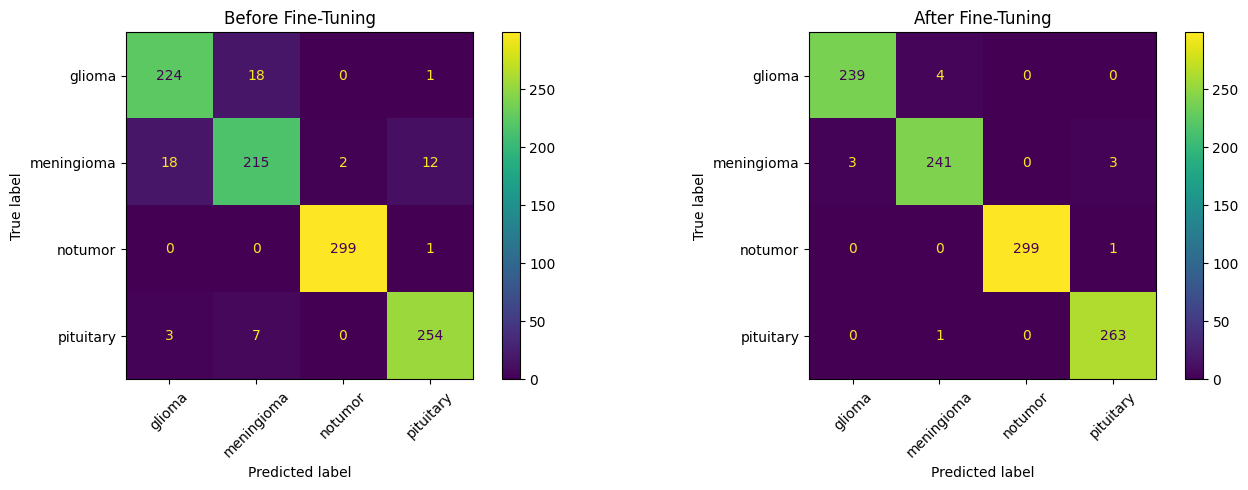

In [37]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before Fine-Tuning
ConfusionMatrixDisplay(confusion_matrix=cm_rn_base, display_labels=train_ds.class_names).plot(ax=axes[0], xticks_rotation=45)
axes[0].set_title("Before Fine-Tuning")

# After Fine-Tuning
ConfusionMatrixDisplay(confusion_matrix=cm_rn_ft, display_labels=train_ds.class_names).plot(ax=axes[1], xticks_rotation=45)
axes[1].set_title("After Fine-Tuning")

plt.tight_layout()
plt.show()

****ResNet50 Classification Reports: Before vs After Fine-Tuning****
Next :

- Printing classification reports to show precision, recall, and F1-score for each class.
- Displaying overall accuracy before and after fine-tuning.
- Comparing results to highlight performance improvements from fine-tuning.

In [38]:
# classification report Before tunning
print(60*'=')
print("1. ResNet50 Classification Report (Before Fine-Tuning)")
print(60*'-')
print(reoprt_rn_base)

# overall  accuracy
print(f"Accuracy Before Fine-Tuning: {acc_rn_base:.2%}")


# classification report After tunning
print(60*'=')
print("2. ResNet50 Classification Report (After Fine-Tuning)")
print(60*'-')
print(report_rn_ft)

# overall  accuracy
print(f"Accuracy After Fine-Tuning: {acc_rn_ft:.2%}")
print(60*'=')

1. ResNet50 Classification Report (Before Fine-Tuning)
------------------------------------------------------------
              precision    recall  f1-score   support

      glioma       0.91      0.92      0.92       243
  meningioma       0.90      0.87      0.88       247
     notumor       0.99      1.00      1.00       300
   pituitary       0.95      0.96      0.95       264

    accuracy                           0.94      1054
   macro avg       0.94      0.94      0.94      1054
weighted avg       0.94      0.94      0.94      1054

Accuracy Before Fine-Tuning: 94.12%
2. ResNet50 Classification Report (After Fine-Tuning)
------------------------------------------------------------
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       243
  meningioma       0.98      0.98      0.98       247
     notumor       1.00      1.00      1.00       300
   pituitary       0.99      1.00      0.99       264

    accuracy              

# **2. EfficientNetB0 Model**
To further explore transfer learning in brain tumor classification, we implemented **EfficientNetB0**, a modern CNN architecture known for its efficient scaling of depth, width, and input resolution. It balances performance and computation, making it ideal for real-world applications like medical imaging.
  
- Loading EfficientNetB0 with ImageNet weights and freezing its base layers.
- Adding a custom classification head with pooling, dropout, and dense layers.
- Defining the complete model by combining the base and custom layers.
- Compiling the model using the Adam optimizer and categorical crossentropy.
- Training the model for 30 epochs with validation on each step.

In [55]:
# Loading EfficientNetB0 base model with pre-trained ImageNet weights
EN_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the EfficientNet base to prevent its weights from updating during training.
EN_base.trainable = False

# Adding a custom classification head on top of EfficientNetB0.
x = EN_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='swish')(x)
x = Dropout(0.3)(x)
EN_pred = Dense(len(train_ds.class_names), activation='softmax')(x)

# Defining the  EfficientNet model by combining base and custom layers.
EfficientNet = Model(inputs = EN_base.input, outputs = EN_pred)

# Compiling the model using the Adam optimizer and categorical crossentropy loss
EfficientNet.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model on the training dataset and validating on the validation set.
EN_history = EfficientNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25
)

Epoch 1/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 35s 242ms/step - accuracy: 0.6636 - loss: 0.8025 - val_accuracy: 0.8784 - val_loss: 0.3442
Epoch 2/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8483 - loss: 0.4127 - val_accuracy: 0.9050 - val_loss: 0.2826
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8593 - loss: 0.3694 - val_accuracy: 0.9069 - val_loss: 0.2621
Epoch 4/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8603 - loss: 0.3602 - val_accuracy: 0.9098 - val_loss: 0.2517
Epoch 5/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8798 - loss: 0.3201 - val_accuracy: 0.8974 - val_loss: 0.2736
Epoch 6/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8841 - loss: 0.3087 - val_accuracy: 0.9250 - val_loss: 0.2204
Epoch 7/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8851 - loss: 0.2863 - val_accuracy: 0.9193 - val_loss: 0.2178
Epoch 8/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8964 - loss: 0.2680 - val_accuracy: 0.9250 -

**Evaluating EfficientNetB0 (Before Fine-Tuning)**
Next :

- Generating predictions on the test dataset using the base EfficientNetB0 model.
- Storing true and predicted labels to evaluate performance.
- Creating a confusion matrix and classification report for detailed metrics.
- Calculating overall accuracy to assess model effectiveness.

In [56]:

# Initializing lists to store the true and predicted labels for the test dataset
Y_true_EN_base = []
Y_pred_EN_base = []

# Generating predictions on the test dataset batch by batch.
for images, labels in test_ds:
    EN_base_preds = EfficientNet.predict(images, verbose=0)
    Y_pred_EN_base.extend(np.argmax(EN_base_preds, axis=1))               
    Y_true_EN_base.extend(np.argmax(labels.numpy(), axis=1))      

# Retrieving class names from the training dataset for labeling the confusion matrix and report.
class_names = train_ds.class_names

# confusion matrix for EfficientNetB0 base predictions.
cm_EN_base = confusion_matrix(Y_true_EN_base, Y_pred_EN_base)

# EfficientNetB0 baseclassification report.
report_EN_base = classification_report(Y_true_EN_base, Y_pred_EN_base, target_names=class_names)

# Calculating overall accuracy EfficientNetB0 base.
acc_EN_base = accuracy_score(Y_true_EN_base, Y_pred_EN_base)

Next,  fine-tuning EfficientNetB0 by unfreezing all layers, using early stopping, and continuing training with a lower learning rate.

In [87]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

# Adding EarlyStopping to prevent overfitting in fine tuning
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    verbose=1,
    min_lr=1e-6
)

callbacks_EN = [early_stop, reduce_lr]

# Unfreezing the base model to enable fine-tuning
EN_base.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
EfficientNet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

# Fine-tuning the model (continuing from the last epoch)
EN_finetune_history = EfficientNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=55,  
    initial_epoch=EN_history.epoch[-1] + 1, 
    callbacks=callbacks_EN
)
   

Epoch 26/55
77/77 ━━━━━━━━━━━━━━━━━━━━ 110s 696ms/step - accuracy: 0.9963 - loss: 0.2500 - val_accuracy: 0.9829 - val_loss: 0.2856 - learning_rate: 1.0000e-04
Epoch 27/55
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.9979 - loss: 0.2446 - val_accuracy: 0.9839 - val_loss: 0.3969 - learning_rate: 1.0000e-04
Epoch 28/55
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.9962 - loss: 0.2419 - val_accuracy: 0.9858 - val_loss: 0.2645 - learning_rate: 1.0000e-04
Epoch 29/55
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.9992 - loss: 0.2355 - val_accuracy: 0.9858 - val_loss: 0.3191 - learning_rate: 1.0000e-04
Epoch 30/55
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.9988 - loss: 0.2369 - val_accuracy: 0.9867 - val_loss: 0.3478 - learning_rate: 1.0000e-04
Epoch 31/55
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.9989 - loss: 0.2335 - val_accuracy: 0.9915 - val_loss: 0.2320 - learning_rate: 1.0000e-04
Epoch 32/55
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/st

Next,  evaluating the fine-tuned **EfficientNetB0** model by generating predictions, creating a confusion matrix and classification report, and calculating overall accuracy.

In [99]:
#EfficientNetB0 Fine Tune Testing.

# Initializing lists to store the true and predicted labels for the test dataset
Y_true_EN_ft = []
Y_pred_EN_ft = []

# Generating predictions on the test dataset batch by batch.
for images, labels in test_ds:
    EN_ft_preds = EfficientNet.predict(images, verbose=0)
    Y_pred_EN_ft.extend(np.argmax(EN_ft_preds, axis=1))               
    Y_true_EN_ft.extend(np.argmax(labels.numpy(), axis=1))      

# Retrieving class names.
class_names = train_ds.class_names

# Creating  confusion matrix for EfficientNetB0 Fine Tune.
cm_EN_ft = confusion_matrix(Y_true_EN_ft, Y_pred_EN_ft)

# EfficientNetB0 Fine Tune classification report.
report_EN_ft = classification_report(Y_true_EN_ft, Y_pred_EN_ft, target_names=class_names)

# Calculating and displaying the overall accuracy of the model on the test dataset
acc_EN_ft = accuracy_score(Y_true_EN_ft, Y_pred_EN_ft)

Next,  combining training history from both phases and plotting EfficientNetB0’s accuracy and loss for training and validation, highlighting where fine-tuning began to clearly visualize its impact on performance over time.

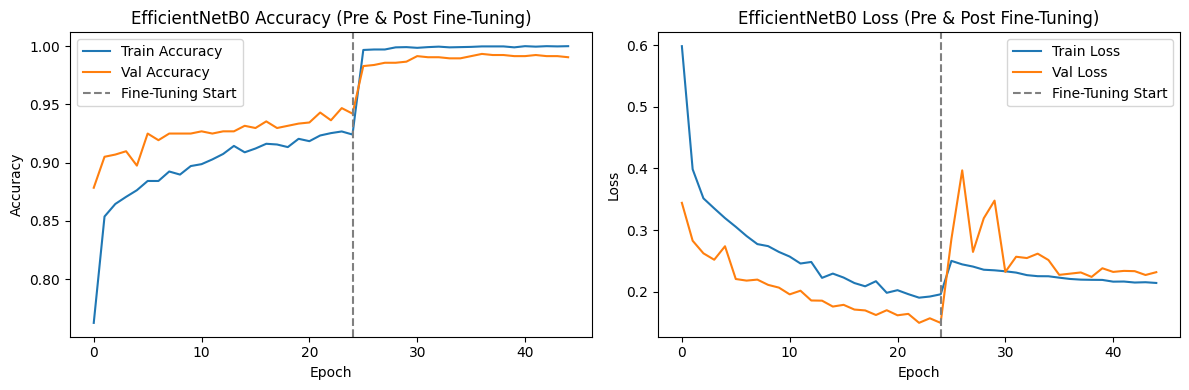

In [100]:
# Combine history from base training and fine-tuning for EfficientNetB0
full_history_EN = {}
for key in EN_history.history:
    full_history_EN[key] = EN_history.history[key] + EN_finetune_history.history[key]

# Plot training and validation accuracy and loss side by side
plt.figure(figsize=(12, 4))

#  Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(full_history_EN['accuracy'], label='Train Accuracy')
plt.plot(full_history_EN['val_accuracy'], label='Val Accuracy')
plt.axvline(x=len(EN_history.history['accuracy'])-1, color='gray', linestyle='--', label='Fine-Tuning Start')
plt.title('EfficientNetB0 Accuracy (Pre & Post Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(full_history_EN['loss'], label='Train Loss')
plt.plot(full_history_EN['val_loss'], label='Val Loss')
plt.axvline(x=len(EN_history.history['loss'])-1, color='gray', linestyle='--', label='Fine-Tuning Start')
plt.title('EfficientNetB0 Loss (Pre & Post Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Next,  displaying side-by-side confusion matrices for EfficientNetB0 before and after fine-tuning to visually compare classification performance and identify improvements in predictions across classes.

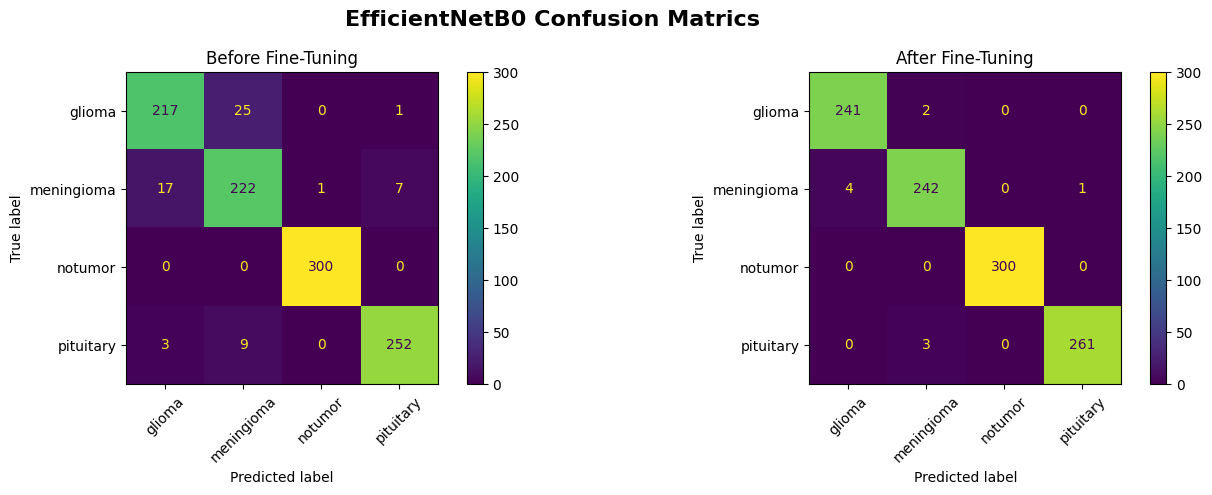

In [101]:
# Create side-by-side Confusion Matrix plots for EfficientNetB0
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("EfficientNetB0 Confusion Matrics", fontsize=16, fontweight='bold')

# Before Fine-Tuning
ConfusionMatrixDisplay(confusion_matrix = cm_EN_base, display_labels=train_ds.class_names).plot(ax=axes[0], xticks_rotation=45)
axes[0].set_title("Before Fine-Tuning")

# After Fine-Tuning
ConfusionMatrixDisplay(confusion_matrix = cm_EN_ft, display_labels=train_ds.class_names).plot(ax=axes[1], xticks_rotation=45)
axes[1].set_title("After Fine-Tuning")

plt.tight_layout()
plt.show()

Finally,  printing EfficientNetB0’s classification reports and overall accuracy before and after fine-tuning to summarize improvements in precision, recall, and overall model performance.

In [102]:
# EfficientNetB0 classification report Before tunning
print(60*'=')
print("1. EfficientNetB0 Classification Report (Before Fine-Tuning)")
print(60*'-')
print(report_EN_base)

# overall  accuracy
print(f"Accuracy Before Fine-Tuning: {acc_EN_base:.2%}")


# EfficientNetB0 classification report After tunning
print(60*'=')
print("2. EfficientNetB0 Classification Report (After Fine-Tuning)")
print(60*'-')
print(report_EN_ft)

# overall  accuracy
print(f"Accuracy After Fine-Tuning: {acc_EN_ft:.2%}")
print(60*'=')

1. EfficientNetB0 Classification Report (Before Fine-Tuning)
------------------------------------------------------------
              precision    recall  f1-score   support

      glioma       0.92      0.89      0.90       243
  meningioma       0.87      0.90      0.88       247
     notumor       1.00      1.00      1.00       300
   pituitary       0.97      0.95      0.96       264

    accuracy                           0.94      1054
   macro avg       0.94      0.94      0.94      1054
weighted avg       0.94      0.94      0.94      1054

Accuracy Before Fine-Tuning: 94.02%
2. EfficientNetB0 Classification Report (After Fine-Tuning)
------------------------------------------------------------
              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       243
  meningioma       0.98      0.98      0.98       247
     notumor       1.00      1.00      1.00       300
   pituitary       1.00      0.99      0.99       264

    accuracy  

# **3. DenseNet121 Model**
To further explore the impact of advanced transfer learning architectures in brain tumor classification, we implemented DenseNet121, known for its dense connectivity and feature reuse, which improves gradient flow and efficiency.

- Loading DenseNet121 with ImageNet weights and freezing its base layers.
- Adding a custom classification head with global pooling, dropout, and dense layers.
- Defining the full model by combining the base and the custom head.
- Compiling the model with the Adam optimizer and categorical crossentropy loss.
- Training the model for 25 epochs with validation to monitor its learning progress.

In [62]:
# Loading DenseNet121 base model with pre-trained ImageNet weights
DN_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the DenseNet121 base to prevent its weights from updating during training
DN_base.trainable = False

# Adding a custom classification head on top of DenseNet121
x = DN_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
DN_pred = Dense(len(train_ds.class_names), activation='softmax')(x)

# Defining the DenseNet121 model by combining base and custom layers
DenseNet = Model(inputs=DN_base.input, outputs=DN_pred)

# Compiling the model using the Adam optimizer and categorical crossentropy loss
DenseNet.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Training the model on the training dataset and validating on the validation set
DN_history = DenseNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 305ms/step - accuracy: 0.3694 - loss: 3.2477 - val_accuracy: 0.6705 - val_loss: 0.9817
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.5066 - loss: 1.1612 - val_accuracy: 0.6467 - val_loss: 0.9087
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.5781 - loss: 1.0081 - val_accuracy: 0.7654 - val_loss: 0.7665
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.6199 - loss: 0.9022 - val_accuracy: 0.7702 - val_loss: 0.7499
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.6370 - loss: 0.8584 - val_accuracy: 0.7759 - val_loss: 0.6909
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.6423 - loss: 0.8157 - val_accuracy: 0.8110 - val_loss: 0.6356
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.6685 - loss: 0.7852 - val_accuracy: 0.7958 - val_loss: 0.5996
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.6850 - loss: 0.7632 - val_accuracy: 0

Next,  evaluating the DenseNet121 model by generating predictions on the test dataset, computing the confusion matrix and classification report, and calculating overall accuracy to assess its initial performance.

In [63]:
# Initializing lists to store the true and predicted labels for the test dataset
Y_true_DN_base = []
Y_pred_DN_base = []

# Generating predictions on the test dataset batch by batch
for images, labels in test_ds:
    DN_base_preds = DenseNet.predict(images, verbose=0)
    Y_pred_DN_base.extend(np.argmax(DN_base_preds, axis=1))
    Y_true_DN_base.extend(np.argmax(labels.numpy(), axis=1))

# Retrieving class names from the training dataset for labeling the confusion matrix and report
class_names = train_ds.class_names

# Confusion matrix for DenseNet121 predictions
cm_DN_base = confusion_matrix(Y_true_DN_base, Y_pred_DN_base)

# Classification report for DenseNet121
report_DN_base = classification_report(Y_true_DN_base, Y_pred_DN_base, target_names=class_names)

# Calculating overall accuracy for DenseNet121
acc_DN_base = accuracy_score(Y_true_DN_base, Y_pred_DN_base)


**Fine-Tuning DenseNet121**
Next,  fine-tuning DenseNet121 by unfreezing all layers, adding EarlyStopping and ReduceLROnPlateau to avoid overfitting and optimize learning rate, recompiling the model with a lower learning rate, and continuing training from the last saved epoch.

In [88]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

# Adding EarlyStopping and ReduceLROnPlateau to prevent overfitting and optimize learning rate
early_stop_DN = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)
reduce_lr_DN = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

callbacks_DN = [early_stop_DN, reduce_lr_DN]

# Unfreezing the DenseNet base model to enable fine-tuning
DN_base.trainable = True

# Recompiling the model with a lower learning rate for fine-tuning
DenseNet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

# Fine-tuning the model (continuing from the last epoch of initial training)
DN_finetune_history = DenseNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch=DN_history.epoch[-1] + 1,
    callbacks=callbacks_DN
)

Epoch 21/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9945 - loss: 0.4208 - val_accuracy: 0.9820 - val_loss: 0.4120 - learning_rate: 1.0000e-04
Epoch 22/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 343ms/step - accuracy: 0.9960 - loss: 0.4160 - val_accuracy: 0.9820 - val_loss: 0.3887 - learning_rate: 1.0000e-04
Epoch 23/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 341ms/step - accuracy: 0.9979 - loss: 0.4088 - val_accuracy: 0.9839 - val_loss: 0.3844 - learning_rate: 1.0000e-04
Epoch 24/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 340ms/step - accuracy: 0.9931 - loss: 0.4093 - val_accuracy: 0.9592 - val_loss: 0.4486 - learning_rate: 1.0000e-04
Epoch 25/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9961 - loss: 0.4033
Epoch 25: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 340ms/step - accuracy: 0.9961 - loss: 0.4033 - val_accuracy: 0.9791 - val_loss: 0.3972 - learning_rate: 1.0000e-04
Epoch 26/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 341ms/step - accu

Next,  evaluating the fine-tuned DenseNet121 model by generating predictions on the test dataset, calculating the confusion matrix, classification report, and overall accuracy to measure improvements after fine-tuning.

In [89]:
# DenseNet121 Fine Tune Testing

# Initializing lists to store the true and predicted labels for the test dataset
Y_true_DN_ft = []
Y_pred_DN_ft = []

# Generating predictions on the test dataset batch by batch
for images, labels in test_ds:
    DN_ft_preds = DenseNet.predict(images, verbose=0)
    Y_pred_DN_ft.extend(np.argmax(DN_ft_preds, axis=1))
    Y_true_DN_ft.extend(np.argmax(labels.numpy(), axis=1))

# Retrieving class names
class_names = train_ds.class_names

# Creating confusion matrix for DenseNet121 Fine Tune
cm_DN_ft = confusion_matrix(Y_true_DN_ft, Y_pred_DN_ft)

# DenseNet121 Fine Tune classification report
report_DN_ft = classification_report(Y_true_DN_ft, Y_pred_DN_ft, target_names=class_names)

# Calculating and displaying the overall accuracy of the model on the test dataset
acc_DN_ft = accuracy_score(Y_true_DN_ft, Y_pred_DN_ft)


Next,  combining the training history of DenseNet121 from both base and fine-tuning phases and plotting the training and validation accuracy and loss to visualize learning progress and the impact of fine-tuning.

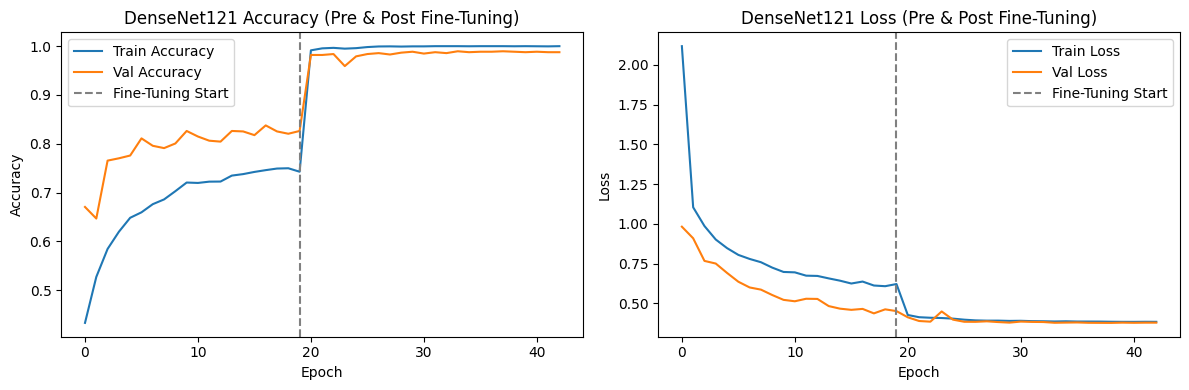

In [90]:
# Combine history from base training and fine-tuning for DenseNet121
full_history_DN = {}
for key in DN_history.history:
    full_history_DN[key] = DN_history.history[key] + DN_finetune_history.history[key]

# Plot training and validation accuracy and loss side by side
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(full_history_DN['accuracy'], label='Train Accuracy')
plt.plot(full_history_DN['val_accuracy'], label='Val Accuracy')
plt.axvline(x=len(DN_history.history['accuracy']) - 1, color='gray', linestyle='--', label='Fine-Tuning Start')
plt.title('DenseNet121 Accuracy (Pre & Post Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(full_history_DN['loss'], label='Train Loss')
plt.plot(full_history_DN['val_loss'], label='Val Loss')
plt.axvline(x=len(DN_history.history['loss']) - 1, color='gray', linestyle='--', label='Fine-Tuning Start')
plt.title('DenseNet121 Loss (Pre & Post Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Next,  visualizing DenseNet121’s confusion matrices side by side before and after fine-tuning to compare improvements in class-wise prediction performance.

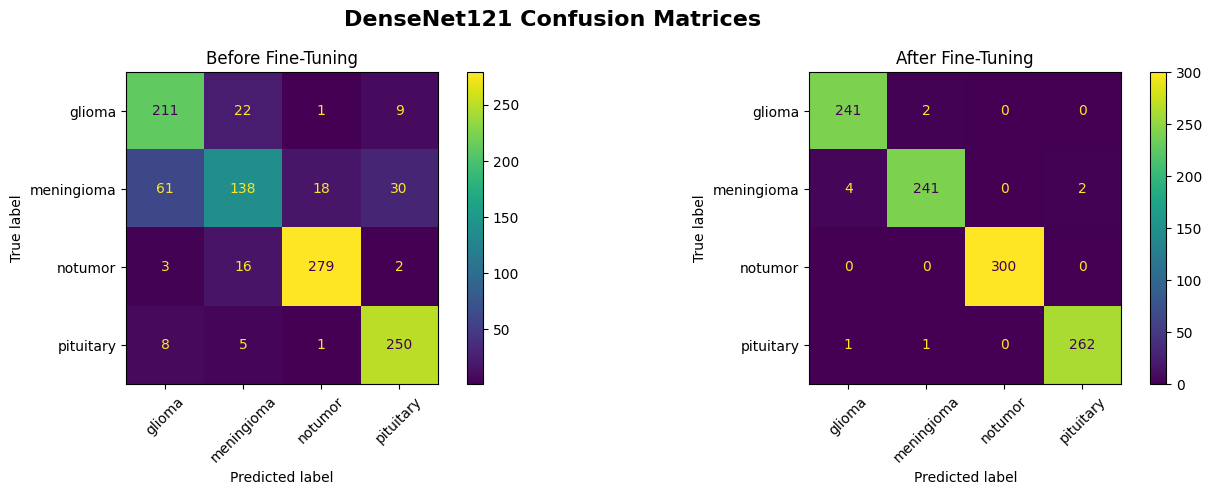

In [103]:
# Create side-by-side Confusion Matrix plots for DenseNet121
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("DenseNet121 Confusion Matrices", fontsize=16, fontweight='bold')

# Before Fine-Tuning
ConfusionMatrixDisplay(confusion_matrix=cm_DN_base, display_labels=train_ds.class_names).plot(ax=axes[0], xticks_rotation=45)
axes[0].set_title("Before Fine-Tuning")

# After Fine-Tuning
ConfusionMatrixDisplay(confusion_matrix=cm_DN_ft, display_labels=train_ds.class_names).plot(ax=axes[1], xticks_rotation=45)
axes[1].set_title("After Fine-Tuning")

plt.tight_layout()
plt.show()


Finally,  printing DenseNet121’s classification reports and overall accuracy before and after fine-tuning to assess the model’s improvement in performance metrics.

In [104]:
# DenseNet121 classification report Before tuning
print(60*'=')
print("1. DenseNet121 Classification Report (Before Fine-Tuning)")
print(60*'-')
print(report_DN_base)

# overall accuracy
print(f"Accuracy Before Fine-Tuning: {acc_DN_base:.2%}")

# DenseNet121 classification report After tuning
print(60*'=')
print("2. DenseNet121 Classification Report (After Fine-Tuning)")
print(60*'-')
print(report_DN_ft)

# overall accuracy
print(f"Accuracy After Fine-Tuning: {acc_DN_ft:.2%}")
print(60*'=')

1. DenseNet121 Classification Report (Before Fine-Tuning)
------------------------------------------------------------
              precision    recall  f1-score   support

      glioma       0.75      0.87      0.80       243
  meningioma       0.76      0.56      0.64       247
     notumor       0.93      0.93      0.93       300
   pituitary       0.86      0.95      0.90       264

    accuracy                           0.83      1054
   macro avg       0.83      0.83      0.82      1054
weighted avg       0.83      0.83      0.83      1054

Accuracy Before Fine-Tuning: 83.30%
2. DenseNet121 Classification Report (After Fine-Tuning)
------------------------------------------------------------
              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       243
  meningioma       0.99      0.98      0.98       247
     notumor       1.00      1.00      1.00       300
   pituitary       0.99      0.99      0.99       264

    accuracy        

#  **4.Custom CNN Model**

To compare with transfer learning approaches, we developed a custom Convolutional Neural Network (CNN) tailored for brain tumor classification. This model was built from scratch to learn features directly from MRI images without relying on pre-trained weights.

- Designing a CNN with multiple Conv2D, ReLU, and MaxPooling layers for feature extraction.
- Adding GlobalAveragePooling and dense layers for classification.
- Applying dropout layers to reduce overfitting.
- Compiling the model with Adam optimizer and categorical crossentropy loss.
- Training the model for 30 epochs with validation to monitor performance.

# Data Augmentation for Custom CNN
To improve generalization and support robust training of the Custom CNN, we are applying offline data augmentation. This helps balance the dataset and expose the model to more diverse examples without relying on pre-trained features.

- Defining source and target paths for the augmented dataset.
- Creating a mirrored folder structure for all classes.
- Copying original images to the new directory for consistency.
- Setting up an ImageDataGenerator to apply transformations like rotation, shifts, brightness changes, and flipping.
- Generating and saving two augmented images per original image to increase dataset size and variation.
This augmentation step is enhancing the model's ability to learn relevant patterns from limited data, making the custom CNN more resilient during training.

In [69]:
# Defining source and target paths for the augmented dataset.
original_train_dir = "/kaggle/working/dataset/train"
augmented_train_dir = "/kaggle/working/dataset/train_augmented"

# Creating a mirrored folder structure for all classes.
for class_name in os.listdir(original_train_dir):
    original_class_path = os.path.join(original_train_dir, class_name)
    new_class_path = os.path.join(augmented_train_dir, class_name)
    os.makedirs(new_class_path, exist_ok=True)

    # Step 1: Copying original images to the new directory for consistency.
    for fname in os.listdir(original_class_path):
        src_path = os.path.join(original_class_path, fname)
        dst_path = os.path.join(new_class_path, fname)
        shutil.copy2(src_path, dst_path)

# Step 2: Setting up an ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest"
)

# Step 3: Generating and saving augmented images
for class_name in os.listdir(original_train_dir):
    class_path = os.path.join(original_train_dir, class_name)
    save_path = os.path.join(augmented_train_dir, class_name)

    for fname in os.listdir(class_path):
        img = load_img(os.path.join(class_path, fname), target_size=(224, 224))
        x = img_to_array(img).reshape((1, 224, 224, 3))

        for i, batch in enumerate(datagen.flow(x, batch_size=1)):
            save_img(os.path.join(save_path, f"aug_{i}_{fname}"), batch[0])
            if i >= 1:  # change this to how many augmented images you want
                break
print("Training data augmentation completed")

Training data augmentation completed


**Loading Augmented Dataset for CNN Training**
We are verifying the image count per class in the augmented training folder to confirm augmentation success. Then, we are loading the augmented dataset using TensorFlow's image_dataset_from_directory, resizing images to 224×224, batching them, and setting labels to categorical for multi-class classification.

In [70]:
aug_train_ds = "/kaggle/working/dataset/train_augmented"

print("Image count per class in train folder:")
for class_name in os.listdir(aug_train_ds):
    class_path = os.path.join(aug_train_ds, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        print(f"  {class_name}: {count} images")

# Loading the training dataset from the specified directory
aug_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    aug_train_ds,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical'
)

Image count per class in train folder:
  glioma: 3405 images
  notumor: 4200 images
  pituitary: 3690 images
  meningioma: 3453 images
Found 14748 files belonging to 4 classes.


# CNN Architecture Variants for Brain Tumor Classification
To explore the impact of network depth and activation functions on performance, we are defining four custom CNN models—each varying in complexity and layer configuration. These models are trained using the augmented dataset and designed specifically for multi-class brain tumor classification.

- base_cnn: A balanced model with four convolutional layers, leaky_relu activations, dropout, and L2 regularization to manage overfitting.
- cnn_1: A lightweight CNN with three convolutional layers and fewer parameters, suitable for fast training and limited resources.
- cnn_2: A deeper CNN with four convolutional layers and wider filters, offering higher capacity for learning complex features.
- cnn_3: A heavier architecture using the swish activation function and deeper layers, aiming for high accuracy with enhanced non-linearity.
Each model ends with global average pooling followed by dense layers and a softmax output layer to handle the 4-class classification task.

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.activations import swish
from tensorflow.keras.callbacks import EarlyStopping

# Defining a balanced base CNN model
def base_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),
        
        # Adding convolutional blocks with leaky ReLU and max pooling
        Conv2D(32, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        Conv2D(64, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        Conv2D(128, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        Conv2D(256, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        # Reducing dimensionality and connecting to dense layers
        GlobalAveragePooling2D(),
        Dense(256, kernel_regularizer=l2(0.001)),
        Activation('leaky_relu'),
        Dropout(0.5),

        Dense(128, kernel_regularizer=l2(0.001)),
        Activation('leaky_relu'),
        Dropout(0.5),

        # Final softmax output layer for multi-class classification
        Dense(num_classes, activation='softmax')
    ])
    return model


# Defining a lightweight CNN variant for faster training
def cnn_1(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(16, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        Conv2D(32, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        Conv2D(64, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        GlobalAveragePooling2D(),
        Dense(64, kernel_regularizer=l2(0.001)),
        Activation('leaky_relu'),
        Dropout(0.4),

        Dense(num_classes, activation='softmax')
    ])
    return model


# Defining a deeper CNN variant with more filters and capacity
def cnn_2(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(64, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        Conv2D(128, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        Conv2D(256, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        Conv2D(512, (3, 3), padding='same'),
        Activation('leaky_relu'),
        MaxPooling2D(),

        GlobalAveragePooling2D(),
        Dense(512, kernel_regularizer=l2(0.001)),
        Activation('leaky_relu'),
        Dropout(0.5),

        Dense(256, kernel_regularizer=l2(0.001)),
        Activation('leaky_relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])
    return model


# Defining a CNN with swish activation for non-linear expressiveness
def cnn_3(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(64, (3, 3), padding='same'),
        Activation(swish),
        MaxPooling2D(),

        Conv2D(128, (3, 3), padding='same'),
        Activation(swish),
        MaxPooling2D(),

        Conv2D(256, (3, 3), padding='same'),
        Activation(swish),
        MaxPooling2D(),

        Conv2D(512, (3, 3), padding='same'),
        Activation(swish),
        MaxPooling2D(),

        GlobalAveragePooling2D(),
        Dense(512, kernel_regularizer=l2(0.001)),
        Activation(swish),
        Dropout(0.4),

        Dense(256, kernel_regularizer=l2(0.001)),
        Activation(swish),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])
    return model


**Comparing CNN Architecture Variants**
To evaluate the effectiveness of each custom CNN variant, we are training all models on the augmented dataset and collecting performance metrics, including validation accuracy, model complexity, and inference speed.

- Defining and compiling four model variants: Base CNN, CNN 1, CNN 2, and CNN 3.
- Training each model for 10 epochs using the same augmented dataset and validation set.
- Storing training history to review learning curves.
- Measuring final validation accuracy to compare generalization.
- Calculating total trainable parameters to assess model size.
- Timing inference on a single batch to evaluate real-time performance.
- Storing all results in a Pandas DataFrame and sorting them by validation accuracy.
This comparison helps us identify the most efficient and accurate CNN architecture for brain tumor classification.

In [72]:
# Step 1: Preparing storage for models and their training histories
model_variants = {
    "Base CNN": base_cnn(),
    "CNN 1": cnn_1(),
    "CNN 2": cnn_2(),
    "CNN 3": cnn_3()
}

history_variants = {}  # To store training histories for each model
results = []           # To store evaluation metrics

# Step 2: Compile, train, and evaluate each model
for name, model in model_variants.items():
    print(f"\nTraining model: {name}")

    # Step 2: Compiling, training, and evaluating each model
    model.compile(
        optimizer=Adam(learning_rate=1e-3), # Clip gradients to avoid exploding values
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Training the model on the augmented dataset with validation
    history = model.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=10,
        verbose=1
    )

    # Saving training history
    history_variants[name] = history

    # Retrieving final validation accuracy from training history
    val_acc = history.history['val_accuracy'][-1]

    # Counting total trainable parameters in the model
    total_params = model.count_params()

    # Measuring inference time on a single validation batch
    sample_batch = next(iter(val_ds))
    x_sample, _ = sample_batch

    start_time = time.time()
    _ = model.predict(x_sample, verbose=0)
    end_time = time.time()
    inference_time = end_time - start_time

    # Storing the evaluation results for models
    results.append({
        "Model": name,
        "Validation Accuracy (%)": round(val_acc * 100, 2),
        "Trainable Parameters": total_params,
        "Inference Time (s)": round(inference_time, 3)
    })

# Step 3: Step 3: Creating results table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Validation Accuracy (%)", ascending=False)


Training model: Base CNN
Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.3962 - loss: 2.3246 - val_accuracy: 0.5964 - val_loss: 1.2825
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.6517 - loss: 1.2138 - val_accuracy: 0.7217 - val_loss: 0.9787
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.7307 - loss: 0.9782 - val_accuracy: 0.7939 - val_loss: 0.7779
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.7842 - loss: 0.8121 - val_accuracy: 0.7958 - val_loss: 0.7205
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.8033 - loss: 0.7229 - val_accuracy: 0.8072 - val_loss: 0.6520
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.8096 - loss: 0.6642 - val_accuracy: 0.8547 - val_loss: 0.5439
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.8349 - loss: 0.5853 - val_accuracy: 0.8091 - val_loss: 0.5901
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy

After training and evaluating all custom CNN variants, we are selecting the best-performing model based on highest validation accuracy. We are retrieving its training history to analyze learning behavior over epochs.

- Identifying the top model from the results DataFrame.
- Retrieving the trained model and its corresponding history.
- Displaying model name and final sorted comparison table.
- Converting the training history into tabular format for review.

In [73]:
# Step 4: Retrieving the best model and its training history
best_model_name = results_df.iloc[0]['Model']
best_CNN_base = model_variants[best_model_name]
Best_CNN_base_history = history_variants[best_model_name]

# Converting the best model's training history into a DataFrame for further use
base_CNN_history = pd.DataFrame(Best_CNN_base_history.history)

# Printing the selected best model
print(f"\nBest model selected based on validation accuracy: {best_model_name}")

# Printing the full model comparison table again for reference
print("\nModel Comparison Results:\n")
print(results_df.to_string(index=False))

# Printing training history in tabular format
print("\nBase Model Training History (Tabular Format):\n")
print(base_CNN_history)


Best model selected based on validation accuracy: CNN 3

Model Comparison Results:

   Model  Validation Accuracy (%)  Trainable Parameters  Inference Time (s)
   CNN 3                    94.78               1945988               0.524
   CNN 2                    87.56               1945988               2.285
Base CNN                    87.18                487620               1.129
   CNN 1                    76.54                 28004               0.708

Base Model Training History (Tabular Format):

   accuracy      loss  val_accuracy  val_loss
0  0.695145  1.523785      0.800570  1.039170
1  0.786073  0.963579      0.830959  0.792143
2  0.821535  0.758147      0.844254  0.699495
3  0.850014  0.614629      0.874644  0.550240
4  0.864049  0.537632      0.867996  0.512839
5  0.887849  0.448498      0.893637  0.410473
6  0.891985  0.415257      0.925926  0.355734
7  0.910361  0.347382      0.928775  0.321923
8  0.925617  0.296768      0.927825  0.336063
9  0.934296  0.265972      

**Evaluating the Best CNN Model**

We are testing the best CNN model by generating predictions, computing the confusion matrix and classification report, and calculating overall accuracy to validate its final performance.

In [74]:
# Initializing lists to store the actual and predicted class indices for the CNN model
Y_true_CNN_base = []
Y_pred_CNN_base = []

# Generating predictions on the validation set (used here as a proxy for testing)
for images, labels in test_ds:  
    CNN_base_preds = best_CNN_base.predict(images, verbose=0)
    Y_pred_CNN_base.extend(np.argmax(CNN_base_preds, axis=1))
    Y_true_CNN_base.extend(np.argmax(labels.numpy(), axis=1))

# Retrieving class names from the training datasets
class_names = train_ds.class_names

# Creating and displaying the confusion matrix
cm_CNN_base = confusion_matrix(Y_true_CNN_base, Y_pred_CNN_base)


# classification report.
report_CNN_base = classification_report(Y_true_CNN_base, Y_pred_CNN_base, target_names=class_names)

# Calculating overall accuracy.
acc_CNN_base = accuracy_score(Y_true_CNN_base, Y_pred_CNN_base)


**Fine-Tuning the Best CNN Model**
We are fine-tuning the best CNN model using label smoothing, early stopping, and a reset learning rate to further improve generalization and prevent overfitting.

In [91]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

# Adding EarlyStopping to prevent overfitting in fine tuning
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

callbacks_CNN = [early_stop]

# Compile with fine-tuned hyperparameters
best_CNN_base.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=['accuracy']
)

# Train further with callbacks
CNN_ft_1=best_CNN_base.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=20,
    initial_epoch=Best_CNN_base_history.epoch[-1] + 1,
    callbacks=callbacks_CNN
)


Epoch 11/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.9886 - loss: 0.4336 - val_accuracy: 0.9810 - val_loss: 0.4126
Epoch 12/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9948 - loss: 0.3876 - val_accuracy: 0.9269 - val_loss: 0.5164
Epoch 13/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9824 - loss: 0.4247 - val_accuracy: 0.9592 - val_loss: 0.4575
Epoch 14/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9952 - loss: 0.3888 - val_accuracy: 0.9810 - val_loss: 0.4037
Epoch 15/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9997 - loss: 0.3708 - val_accuracy: 0.9810 - val_loss: 0.3988
Epoch 16/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9902 - loss: 0.3898 - val_accuracy: 0.9459 - val_loss: 0.5122
Epoch 17/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.9733 - loss: 0.4532 - val_accuracy: 0.9630 - val_loss: 0.4586
Epoch 18/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - accuracy: 0.9921 -

Next,**Fine-Tuning (Phase 2)**
We are continuing fine-tuning with reduced label smoothing and a lower learning rate to refine learning further. Early stopping is helping prevent overfitting during extended training.

In [92]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

# Adding EarlyStopping to prevent overfitting in fine tuning
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

callbacks_CNN = [early_stop]

best_CNN_base.compile(
    optimizer=Adam(learning_rate=1e-4),  # Lower LR often improves convergence
    loss=loss_fn,
    metrics=['accuracy']
)

# Continue training 
CNN_ft_2 = best_CNN_base.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=30,  # Add more epochs
    initial_epoch=CNN_ft_1.epoch[-1] + 1,
    callbacks=callbacks_CNN
)

Epoch 21/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - accuracy: 0.9998 - loss: 0.2180 - val_accuracy: 0.9848 - val_loss: 0.2511
Epoch 22/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 1.0000 - loss: 0.2145 - val_accuracy: 0.9839 - val_loss: 0.2544
Epoch 23/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9999 - loss: 0.2133 - val_accuracy: 0.9839 - val_loss: 0.2542
Epoch 24/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 1.0000 - loss: 0.2126 - val_accuracy: 0.9858 - val_loss: 0.2529
Epoch 25/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 1.0000 - loss: 0.2118 - val_accuracy: 0.9839 - val_loss: 0.2553
Epoch 26/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 1.0000 - loss: 0.2117 - val_accuracy: 0.9858 - val_loss: 0.2538
Epoch 27/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 1.0000 - loss: 0.2108 - val_accuracy: 0.9839 - val_loss: 0.2515


**Fine-Tuning (Phase 3)**
We are performing final fine-tuning with zero label smoothing and a stable low learning rate to maximize accuracy. Early stopping continues to prevent overfitting during extended training.

In [93]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.00)

# Adding EarlyStopping to prevent overfitting in fine tuning
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

callbacks_CNN = [early_stop]

best_CNN_base.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

# Continue training 
CNN_ft_3 = best_CNN_base.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=50,  # Add more epochs
    initial_epoch=CNN_ft_2.epoch[-1] + 1,
    callbacks=callbacks_CNN
)

Epoch 28/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - accuracy: 0.9994 - loss: 0.0181 - val_accuracy: 0.9820 - val_loss: 0.0922
Epoch 29/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9989 - loss: 0.0139 - val_accuracy: 0.9858 - val_loss: 0.0918
Epoch 30/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9998 - loss: 0.0103 - val_accuracy: 0.9848 - val_loss: 0.0920
Epoch 31/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9996 - loss: 0.0108 - val_accuracy: 0.9858 - val_loss: 0.0928
Epoch 32/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9999 - loss: 0.0091 - val_accuracy: 0.9858 - val_loss: 0.0883
Epoch 33/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9977 - loss: 0.0147 - val_accuracy: 0.9848 - val_loss: 0.0847
Epoch 34/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9998 - loss: 0.0095 - val_accuracy: 0.9877 - val_loss: 0.0829
Epoch 35/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.9999 -

**Fine-Tuning (Phase 4 - Final Refinement)**
We are completing the fine-tuning process with a very low learning rate and no label smoothing, using early stopping to carefully refine weights for optimal generalization.

In [94]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.00)

# Adding EarlyStopping to prevent overfitting in fine tuning
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

callbacks_CNN = [early_stop]

best_CNN_base.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

# Continue training 
CNN_ft_4 = best_CNN_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,  # Add more epochs
    initial_epoch=CNN_ft_3.epoch[-1] + 1,
    callbacks=callbacks_CNN
)

Epoch 41/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.9877 - val_loss: 0.0876
Epoch 42/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.9877 - val_loss: 0.0880
Epoch 43/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9999 - loss: 0.0078 - val_accuracy: 0.9848 - val_loss: 0.0902
Epoch 44/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.9848 - val_loss: 0.0925
Epoch 45/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9999 - loss: 0.0076 - val_accuracy: 0.9839 - val_loss: 0.0939
Epoch 46/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.9848 - val_loss: 0.0904
Epoch 47/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9839 - val_loss: 0.0917


**Final Evaluation After All Fine-Tuning Phases**
We are generating predictions using the fully fine-tuned CNN model, computing the confusion matrix and classification report, and calculating final accuracy to assess overall performance improvement.

In [95]:
# Initialize prediction lists
Y_true_CNN_ft = []
Y_pred_CNN_ft = []

# Generate predictions after fine-tuning
for images, labels in test_ds:
    preds = best_CNN_base.predict(images, verbose=0)
    Y_pred_CNN_ft.extend(np.argmax(preds, axis=1))
    Y_true_CNN_ft.extend(np.argmax(labels.numpy(), axis=1))

# Confusion matrix, classification report, and accuracy
cm_CNN_ft = confusion_matrix(Y_true_CNN_ft, Y_pred_CNN_ft)

# classification report.
report_CNN_ft = classification_report(Y_true_CNN_ft, Y_pred_CNN_ft, target_names=train_ds.class_names)

# Calculating overall accuracy.
acc_CNN_ft = accuracy_score(Y_true_CNN_ft, Y_pred_CNN_ft)

**Training History Across All Fine-Tuning Phases**
We are combining training histories from all fine-tuning phases of the best CNN model and plotting accuracy and loss trends. Vertical lines indicate the start of each fine-tuning phase to help visualize performance changes over time.

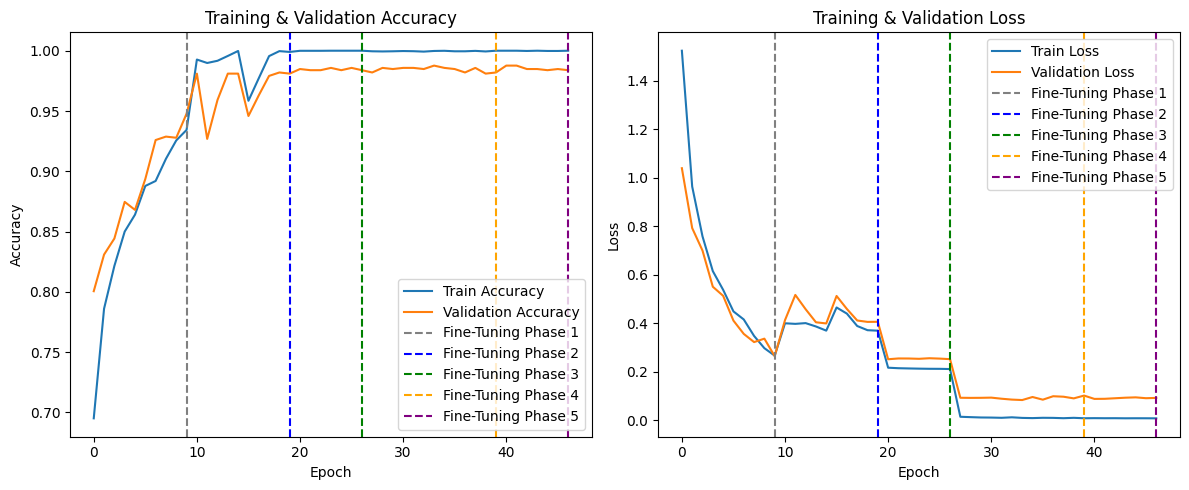

In [96]:
# Combining training histories from all fine-tuning phases
full_history_CNN = {}
for key in Best_CNN_base_history.history:
    full_history_CNN[key] = (
        Best_CNN_base_history.history[key] +
        CNN_ft_1.history[key] +
        CNN_ft_2.history[key] +
        CNN_ft_3.history[key] +
        CNN_ft_4.history[key]
    )

# Calculating starting indices for each fine-tuning phase
phase1_start = len(Best_CNN_base_history.history['accuracy'])
phase2_start = phase1_start + len(CNN_ft_1.history['accuracy'])
phase3_start = phase2_start + len(CNN_ft_2.history['accuracy'])
phase4_start = phase3_start + len(CNN_ft_3.history['accuracy'])
phase5_start = phase4_start + len(CNN_ft_4.history['accuracy'])

# Creating accuracy and loss plots
plt.figure(figsize=(12, 5))

# # Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(full_history_CNN['accuracy'], label='Train Accuracy')
plt.plot(full_history_CNN['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=phase1_start-1, color='gray', linestyle='--', label='Fine-Tuning Phase 1')
plt.axvline(x=phase2_start-1, color='blue', linestyle='--', label='Fine-Tuning Phase 2')
plt.axvline(x=phase3_start-1, color='green', linestyle='--', label='Fine-Tuning Phase 3')
plt.axvline(x=phase4_start-1, color='orange', linestyle='--', label='Fine-Tuning Phase 4')
plt.axvline(x=phase5_start-1, color='purple', linestyle='--', label='Fine-Tuning Phase 5')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(full_history_CNN['loss'], label='Train Loss')
plt.plot(full_history_CNN['val_loss'], label='Validation Loss')
plt.axvline(x=phase1_start-1, color='gray', linestyle='--', label='Fine-Tuning Phase 1')
plt.axvline(x=phase2_start-1, color='blue', linestyle='--', label='Fine-Tuning Phase 2')
plt.axvline(x=phase3_start-1, color='green', linestyle='--', label='Fine-Tuning Phase 3')
plt.axvline(x=phase4_start-1, color='orange', linestyle='--', label='Fine-Tuning Phase 4')
plt.axvline(x=phase5_start-1, color='purple', linestyle='--', label='Fine-Tuning Phase 5')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


Next, **Confusion Matrix Comparison: Base vs Fine-Tuned**
We are visualizing and comparing confusion matrices side-by-side before and after fine-tuning to observe improvements in class-wise predictions and overall model performance.

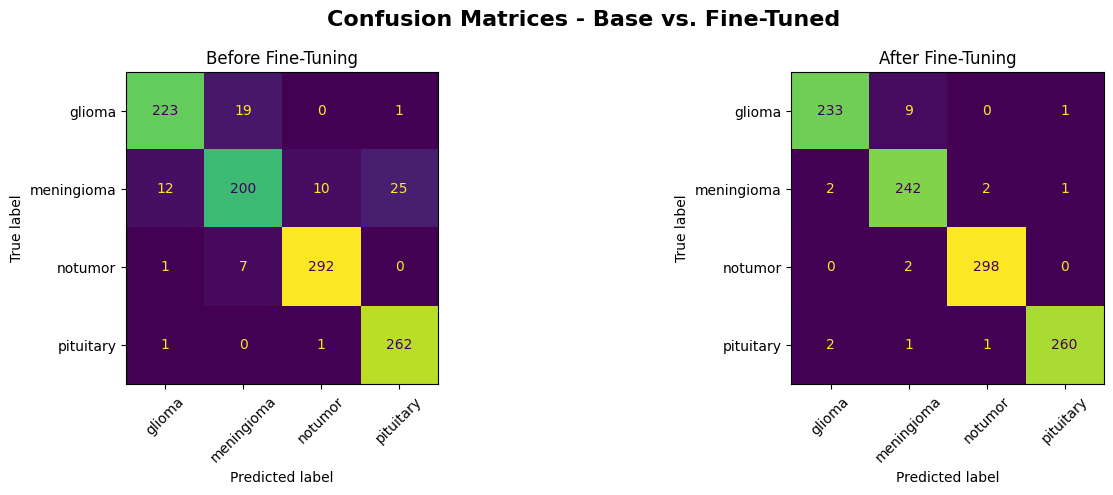

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Confusion Matrices - Base vs. Fine-Tuned", fontsize=16, fontweight='bold')

# Plotting confusion matrix before fine-tuning
ConfusionMatrixDisplay(confusion_matrix=cm_CNN_base, display_labels=train_ds.class_names).plot(ax=axes[0], xticks_rotation=45, colorbar=False)
axes[0].set_title("Before Fine-Tuning")

# Plotting confusion matrix after fine-tuning
ConfusionMatrixDisplay(confusion_matrix=cm_CNN_ft, display_labels=train_ds.class_names).plot(ax=axes[1], xticks_rotation=45, colorbar=False)
axes[1].set_title("After Fine-Tuning")

plt.tight_layout()
plt.show()

Finally,  printing the CNN model’s classification reports and overall accuracy before and after fine-tuning to evaluate performance gains in precision, recall, and overall classification accuracy.

In [98]:
print("="*60)
print("Classification Report - Base CNN")
print("-"*60)
print(report_CNN_base)
print(f"\nAccuracy Before Fine-Tuning: {acc_CNN_base:.2%}")
print("="*60)

print("Classification Report - Fine-Tuned CNN")
print("-"*60)
print(report_CNN_ft)
print(f"\nAccuracy After Fine-Tuning: {acc_CNN_ft:.2%}")
print("="*60)


Classification Report - Base CNN
------------------------------------------------------------
              precision    recall  f1-score   support

      glioma       0.94      0.92      0.93       243
  meningioma       0.88      0.81      0.85       247
     notumor       0.96      0.97      0.97       300
   pituitary       0.91      0.99      0.95       264

    accuracy                           0.93      1054
   macro avg       0.92      0.92      0.92      1054
weighted avg       0.93      0.93      0.93      1054


Accuracy Before Fine-Tuning: 92.69%
Classification Report - Fine-Tuned CNN
------------------------------------------------------------
              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       243
  meningioma       0.95      0.98      0.97       247
     notumor       0.99      0.99      0.99       300
   pituitary       0.99      0.98      0.99       264

    accuracy                           0.98      1054
   macro

# Final Model Comparison
We are generating and comparing classification metrics (accuracy, precision, recall, F1-score) for all fine-tuned models—ResNet50, EfficientNetB0, DenseNet121, and Custom CNN. Results are formatted into a table with percentage values to clearly highlight performance differences across models.

In [105]:
# Accessing classification reports after fine-tuning
report_rn_ft     # ResNet50 (after fine-tuning)
report_EN_ft     # EfficientNetB0 (after fine-tuning)
report_DN_ft     # DenseNet121 (after fine_tuning)
report_CNN_ft    # CNN (after fine-tuning)

# Generating classification reports as dictionaries
report_rn_ft_dict = classification_report(Y_true_rn_ft, Y_pred_rn_ft, target_names=train_ds.class_names, output_dict=True)
report_EN_ft_dict = classification_report(Y_true_EN_ft, Y_pred_EN_ft, target_names=train_ds.class_names, output_dict=True)
report_CNN_ft_dict = classification_report(Y_true_CNN_ft, Y_pred_CNN_ft, target_names=train_ds.class_names, output_dict=True)
report_DN_ft_dict = classification_report(Y_true_DN_ft, Y_pred_DN_ft, target_names=train_ds.class_names, output_dict=True)

# Extracting macro average precision, recall, and F1-score
rn_macro = report_rn_ft_dict['macro avg']
en_macro = report_EN_ft_dict['macro avg']
dn_macro = report_DN_ft_dict['macro avg']
cnn_macro = report_CNN_ft_dict['macro avg']

# Creating a DataFrame to compare models
comparison_df = pd.DataFrame({
    'Model': ['ResNet50', 'EfficientNetB0', 'DenseNet', 'Custom CNN'],
    'Accuracy': [acc_rn_ft, acc_EN_ft, acc_DN_ft, acc_CNN_ft],
    'Precision (Avg)': [rn_macro['precision'], en_macro['precision'], dn_macro['precision'], cnn_macro['precision']],
    'Recall (Avg)': [rn_macro['recall'], en_macro['recall'], dn_macro['recall'], cnn_macro['recall']],
    'F1-Score (Avg)': [rn_macro['f1-score'], en_macro['f1-score'], dn_macro['f1-score'], cnn_macro['f1-score']],
})


# Creating a formatted copy to display metrics as percentages
comparison_df_percent = comparison_df.copy()

# Formatting all numeric metric columns to percentage strings with two decimal places
for col in comparison_df_percent.columns[1:]:
    comparison_df_percent[col] = (comparison_df_percent[col] * 100).map("{:.2f}%".format)

# Displaying the formatted comparison table
comparison_df_percent

,Model,Accuracy,Precision (Avg),Recall (Avg),F1-Score (Avg)
0,ResNet50,98.86%,98.81%,98.80%,98.80%
1,EfficientNetB0,99.05%,98.99%,99.00%,99.00%
2,DenseNet,99.05%,99.00%,99.00%,98.99%
3,Custom CNN,98.01%,97.96%,97.92%,97.93%


# Accuracy Comparison Before and After Tuning
We are visualizing model accuracies before and after fine-tuning using a grouped bar chart, highlighting improvements for ResNet50, EfficientNetB0, DenseNet, and the Custom CNN.

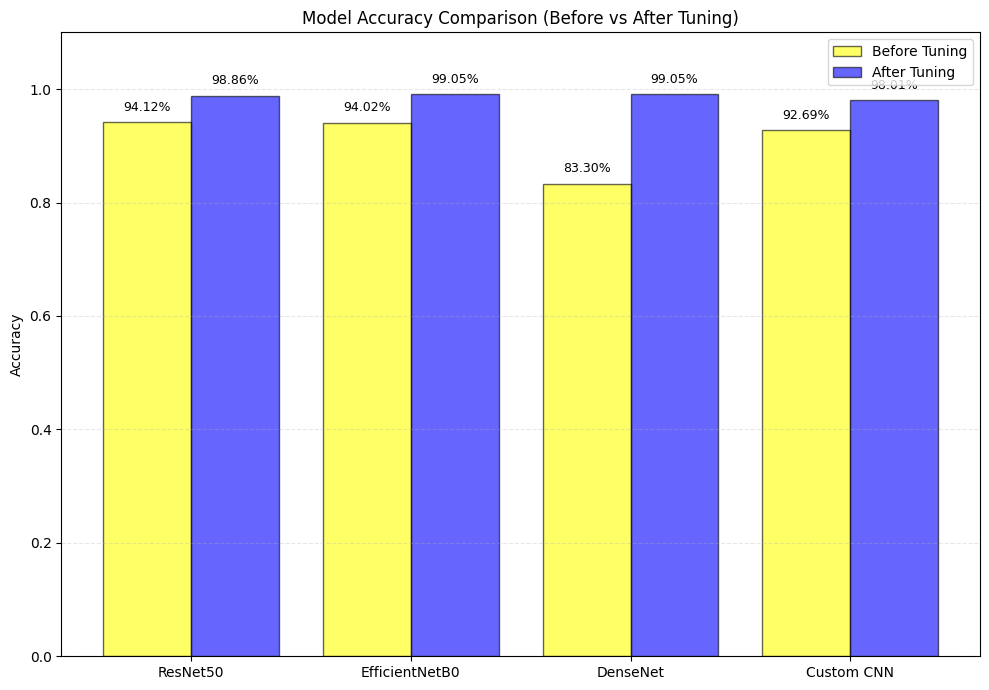

In [106]:
# Defining model names and their accuracies before and after fine-tuning
models = ['ResNet50', 'EfficientNetB0', 'DenseNet', 'Custom CNN']
acc_before = [acc_rn_base, acc_EN_base, acc_DN_base, acc_CNN_base]
acc_after = [acc_rn_ft, acc_EN_ft, acc_DN_ft, acc_CNN_ft]

# Bar positions setup
x = range(len(models))
bar_width = 0.4
plt.figure(figsize=(10, 7))

# Ploting bars Before and After Tuning
bar_BT = plt.bar(x, acc_before, width=bar_width, label='Before Tuning',
                 color='yellow', alpha=0.6, edgecolor='black')
bar_AT = plt.bar([i + bar_width for i in x], acc_after, width=bar_width, label='After Tuning',
                 color='blue', alpha=0.6, edgecolor='black')

# accuracy labels
for bar in bar_BT + bar_AT:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.015, f'{height*100:.2f}%', 
             ha='center', va='bottom', fontsize=9)

# Labels and formatting & displaying the plot
plt.xticks([i + bar_width / 2 for i in x], models)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (Before vs After Tuning)')
plt.ylim(0, 1.1)  # more room above bars
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [107]:
# Finding the model with highest accuracy after tuning
best_index = acc_after.index(max(acc_after))
best_model = models[best_index]
best_accuracy = acc_after[best_index]

print(f"The most efficient model is: {best_model} with an accuracy of {best_accuracy*100:.2f}% after tuning.")

The most efficient model is: EfficientNetB0 with an accuracy of 99.05% after tuning.


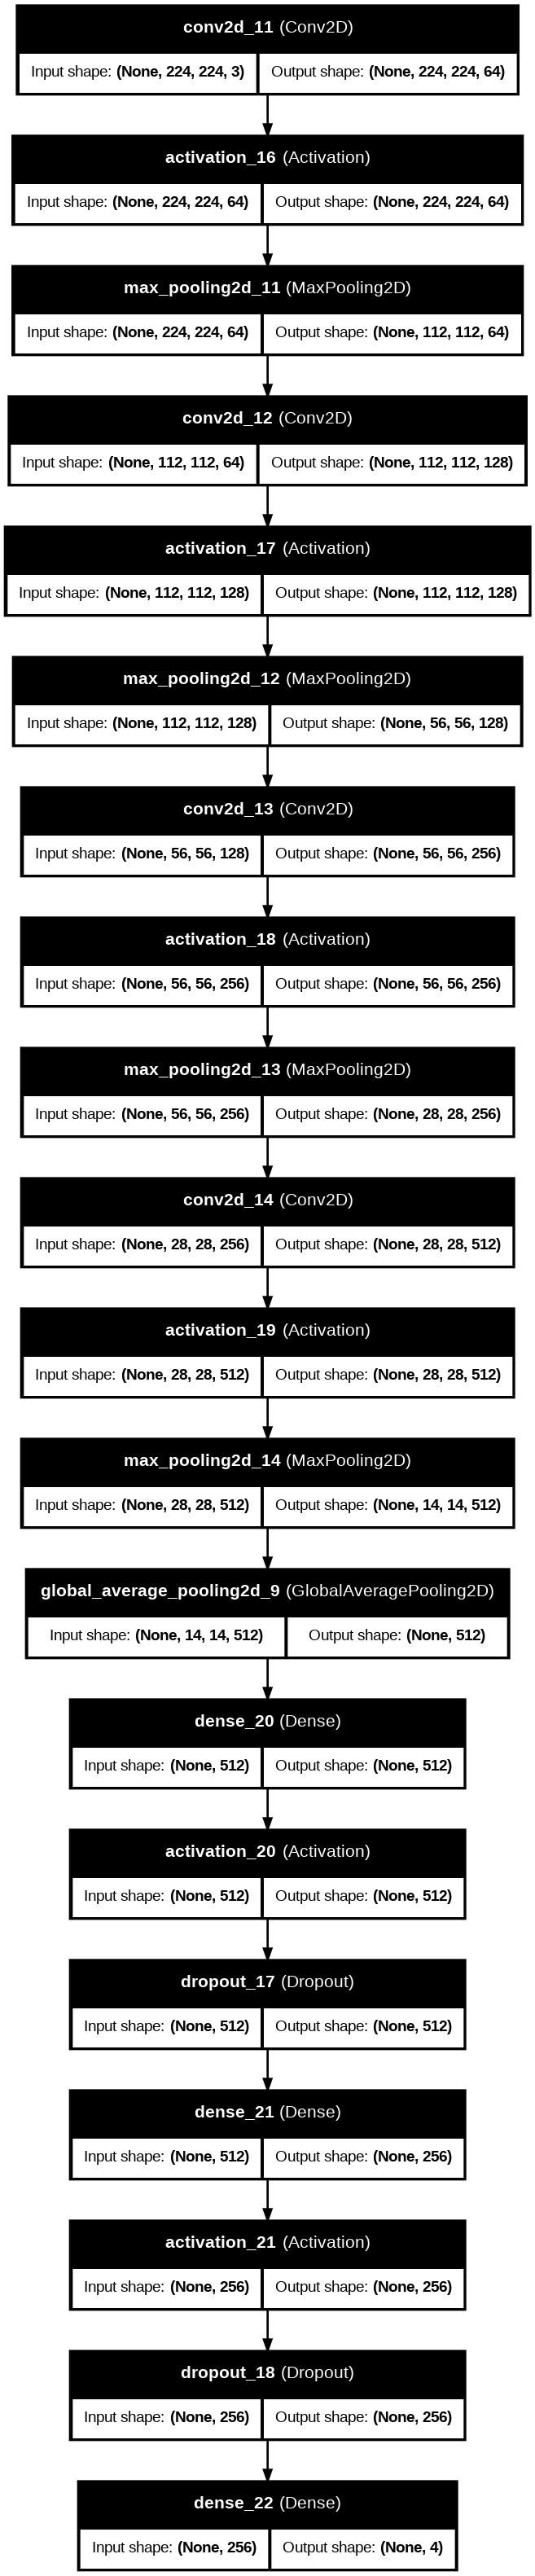

In [86]:
!pip install pydot
!pip install graphviz

from tensorflow.keras.utils import plot_model

# Generate a smaller image with readable details
plot_model(
    best_CNN_base,
    to_file='cnn_model_architecture_small.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=96,  # Try 72, 96, or 120 depending on your poster resolution
    rankdir='TB'  # Top to Bottom; you can try 'LR' for Left to Right layout
)